In [1]:
import os
BAR = 'Barcodes2d'
ROOT = os.path.join(open('../root').read().strip(), 'common')
print ROOT
img_path = os.path.join(os.path.dirname(ROOT), BAR, 'Images')
print img_path
conf_path = os.path.join(os.path.dirname(ROOT), BAR, 'Annotations')
print conf_path
voc_path = os.path.join(os.path.dirname(ROOT), 'VOC', 'JPEGImages')

/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes2d/Images
/home/nik-kochetov/work/Barcodes2d/Annotations


In [2]:
import keras
import os
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Reshape
from keras.applications.vgg16 import VGG16
import math
import numpy as np
%matplotlib notebook

Using Theano backend.


In [3]:
from model import SSDModel
ssd_model = SSDModel()

(37, 37, 24, 1)
(37, 37, 6, 1)
(18, 18, 24, 1)
(18, 18, 6, 1)
(7, 7, 24, 1)
(7, 7, 6, 1)
(5, 5, 24, 1)
(5, 5, 6, 1)
(3, 3, 24, 1)
(3, 3, 6, 1)
(1, 1, 24, 1)
(1, 1, 6, 1)


In [4]:
import sampler
reload(sampler)
from sampler import Sampler
sampler = Sampler(conf_path)
#sampler.dump(BAR)
sampler.load(BAR)
print len(sampler.train)
print len(sampler.test)

loaded 15642 train 3947 test
15642
3947


In [5]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(img_path, voc_path, ssd_model, sampler.train)

In [8]:
import converter
reload(converter)
from converter import Converter
ssd_converter = Converter(ROOT)
ssd_converter.load('bar2d_rects.p')
#ssd_converter.process_rects(conf_path, ssd_model, print_step=100) #, count=100)
ssd_converter.add_empty_processed_rect(ssd_model)

17823 loaded


In [9]:
#ssd_converter.dump("bar2d_rects.p")

In [10]:
res = ssd_generator.generate(ssd_converter.processed_rects, 1)

In [19]:
x, y = res.next()
print x['input'].shape, [(_,b.shape) for _, b in y.items()]

(1, 300, 300, 3) [('block8_class', (1, 3, 3, 6, 1)), ('block4_class', (1, 37, 37, 6, 1)), ('block6_class', (1, 7, 7, 6, 1)), ('block9_class', (1, 1, 1, 6, 1)), ('block4_bbox', (1, 37, 37, 48, 1)), ('block7_bbox', (1, 5, 5, 48, 1)), ('block5_class', (1, 18, 18, 6, 1)), ('block7_class', (1, 5, 5, 6, 1)), ('block5_bbox', (1, 18, 18, 48, 1)), ('block6_bbox', (1, 7, 7, 48, 1)), ('block8_bbox', (1, 3, 3, 48, 1)), ('block9_bbox', (1, 1, 1, 48, 1))]


In [20]:
block = y['block5_bbox']
print block[np.nonzero(block)]

[ 0.07075371  0.25188321  0.15843984  0.39024145  1.          1.          1.
  1.          0.07075371  0.15754493  0.15843984  0.39024145  1.          1.
  1.          1.          0.07075371  0.06320665  0.15843984  0.39024145
  1.          1.          1.          1.          0.07075371 -0.03113163
  0.15843984  0.39024145  1.          1.          1.          1.
  0.07075371 -0.12546991  0.15843984  0.39024145  1.          1.          1.
  1.          0.07075371 -0.21980819  0.15843984  0.39024145  1.          1.
  1.          1.          0.07075371 -0.31414647  0.15843984  0.39024145
  1.          1.          1.          1.        ]


In [21]:
print 'Code_39_Check_0313_58.xml' in ssd_converter.processed_rects.keys()

False


In [24]:
block.shape

(1, 18, 18, 48, 1)

In [26]:
from keras import objectives
from keras import backend as K

def bbox_loss(y_true, y_pred):
    return 100 * objectives.mean_absolute_error(y_true[:,:,:,:24,:], y_pred * y_true[:,:,:,24:,:])

In [27]:
y_true = K.variable(block)
block_changed = np.copy(block[:,:,:,:24,:])
block_changed[np.nonzero(block[:,:,:,24:,:])] = block[np.nonzero(block[:,:,:,24:,:])] + 0.1
block_changed +=  0.5
y_pred = K.variable(block_changed)
out = K.eval(bbox_loss(y_true, y_pred))
print out.shape

(1, 18, 18, 24)


In [28]:
print out[np.nonzero(out)]

[ 60.00000381  60.00000381  60.00000381  60.00000381  60.00000381
  60.00000381  60.00000381  60.00000381  60.00000381  59.99999619
  60.00000381  60.00000381  60.00000381  59.99999619  60.00000381
  60.00000381  60.00000381  60.00000381  60.00000381  60.00000381
  60.00000381  60.00000381  60.00000381  60.00000381  60.00000381
  60.00000381  60.00000381  60.00000381]


In [29]:
loss_map = {}
for name in ssd_model.bbox_names:
    loss_map[name] = bbox_loss
for name in ssd_model.cls_names:
    loss_map[name] = 'binary_crossentropy'
print loss_map

{'block8_class': 'binary_crossentropy', 'block4_class': 'binary_crossentropy', 'block6_class': 'binary_crossentropy', 'block9_class': 'binary_crossentropy', 'block4_bbox': <function bbox_loss at 0x7f6a04db1d70>, 'block7_bbox': <function bbox_loss at 0x7f6a04db1d70>, 'block5_class': 'binary_crossentropy', 'block7_class': 'binary_crossentropy', 'block5_bbox': <function bbox_loss at 0x7f6a04db1d70>, 'block6_bbox': <function bbox_loss at 0x7f6a04db1d70>, 'block8_bbox': <function bbox_loss at 0x7f6a04db1d70>, 'block9_bbox': <function bbox_loss at 0x7f6a04db1d70>}


In [30]:
# updatable plot
# a minimal example (sort of)

import matplotlib.pyplot as plt

class Row:
    def __init__(self, agg=10, level_size=10):
        self.agg = agg
        self.level_size = level_size
        self.batch = []
        self.levels = []
        
    def _add(self, val, level=0):
        if len(self.levels) == level:
            self.levels.append([])
        self.levels[level].append(val)
        if len(self.levels[level]) >= 2 * self.level_size:
            self._add(np.mean(self.levels[level][:-self.level_size]), level + 1)
            self.levels[level] = self.levels[level][-self.level_size:]
        
    def append(self, val):
        self.batch.append(val)
        if len(self.batch) > self.agg:
            self.batch = self.batch[1:]
        self._add(np.mean(self.batch))
            
    def get(self):
        #print self.levels
        res = []
        for vals in self.levels:
            res = vals + res
        return -np.log(res)
        

class PlotLosses(keras.callbacks.Callback):
    
    def __init__(self, ssd_model):
        self.ssd_model = ssd_model
    
    def on_train_begin(self, logs={}):
        self.bbox_losses = {}
        self.cls_losses = {}
        self.plot_legend = True
        
        for name in ssd_model.bbox_names:
            self.bbox_losses[name] = Row()
        for name in ssd_model.cls_names:
            self.cls_losses[name] = Row()
        
        self.fig, (self.ax_bbox, self.ax_cls) = plt.subplots(2, figsize=(12, 16))
        
    def _append(self, logs={}):
        for name in ssd_model.bbox_names:
                self.bbox_losses[name].append(logs.get(name + '_loss'))
        for name in ssd_model.cls_names:
                self.cls_losses[name].append(logs.get(name + '_loss'))
                
        
    def _plot(self):
        #clear_output(wait=True)
        
        self.ax_bbox.cla()
        self.ax_cls.cla()
        
        for name, vals in self.bbox_losses.items():
            self.ax_bbox.plot(vals.get(), label=name)
            
        for name, vals in self.cls_losses.items():
            self.ax_cls.plot(vals.get(), label=name)
        
        if self.plot_legend:
            bbox_to_anchor=(1.2, 1)
            self.ax_bbox.legend(bbox_to_anchor=bbox_to_anchor)
            self.ax_cls.legend(bbox_to_anchor=bbox_to_anchor)
            self.plot_legend = False
            
        self.fig.canvas.draw()
        
    def on_batch_end(self, batch, logs={}):
        #print logs
        self._append(logs)
        self._plot()
        

    def on_epoch_end(self, epoch, logs={}):
        self._append(logs)
        self._plot()
        
plot_losses = PlotLosses(ssd_model)

In [31]:
import time
date = time.strftime("%d-%m-%Y")
date

'24-12-2017'

In [32]:
ssd_model.model.compile(optimizer='adam', loss=loss_map)

In [33]:
names = 'model.' + date + '.ssd.{epoch:02d}.hdf5'
save_callback = keras.callbacks.ModelCheckpoint(names, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csv_logger = keras.callbacks.CSVLogger('log.csv', append=True, separator='\t')

<IPython.core.display.Javascript object>


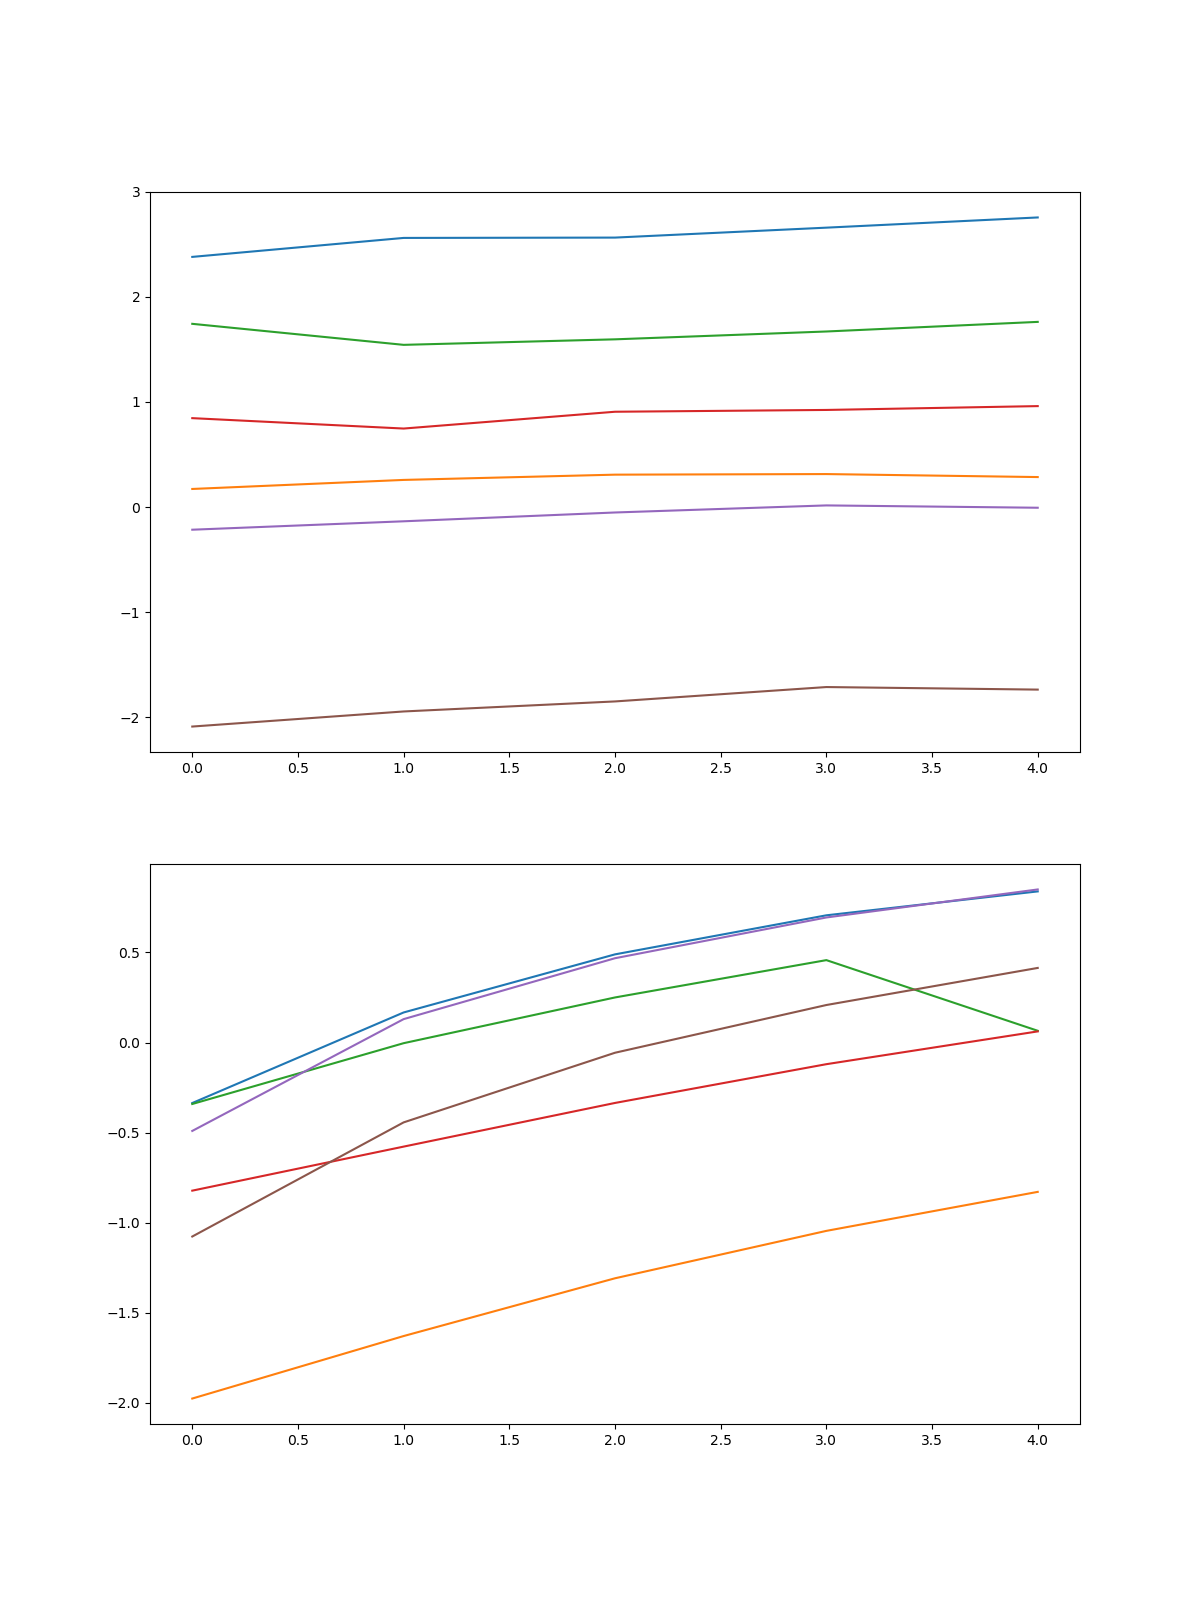

Epoch 1/8
  5/278 [..............................] - ETA: 78640s - loss: 13.7395 - block4_bbox_loss: 0.0636 - block5_bbox_loss: 0.1718 - block6_bbox_loss: 0.3827 - block7_bbox_loss: 0.7517 - block8_bbox_loss: 1.0063 - block9_bbox_loss: 5.6751 - block4_class_loss: 2.2903 - block5_class_loss: 0.9401 - block6_class_loss: 0.6610 - block7_class_loss: 0.4277 - block8_class_loss: 0.4323 - block9_class_loss: 0.9369

In [ ]:
ssd_model.model.fit_generator(ssd_generator.generate(ssd_converter.processed_rects, 64),
        steps_per_epoch= min(200000000000000000, len(ssd_converter.processed_rects) / 64) , epochs=8, 
        callbacks=[save_callback, csv_logger, plot_losses])

In [28]:
ssd_model.model.save_weights("model.h5")

In [6]:
from PIL import Image

def generate_for_bbox(rects_all, shapes):
    all_bbox = []
    all_cls = []
    for rects, shape in zip(rects_all, shapes):
        rat_bbox = []
        rat_cls = []
        for rect_lst in rects:
            bbox = np.zeros(list(shape) + [4])
            cls = np.zeros(list(shape) + [4])
            #print bbox.shape, cls.shape
            for rect in rect_lst:
                y, x = map(int, rect[:2])
                cls[y,x] = [1,1,1,1]
                bbox[y][x] = rect[2:]
            rat_bbox.append(bbox)
            rat_cls.append(cls)
        tmp_bbox = np.concatenate(rat_bbox, axis=2)
        tmp_cls = np.concatenate(rat_cls, axis=2)
        #print tmp_bbox.shape, tmp_cls.shape
        all_bbox.append(tmp_bbox)
        all_cls.append(tmp_cls)
    return np.array(all_bbox), np.array(all_cls)

def generate(path, shapes, processed, batch_size, bbox_names, cls_names):
    batch_x = []
    batch_y = [[] for _ in range(2 * len(shapes))]
    while 1:
        files = os.listdir(path)
        for processed_key in processed.keys():
            name = os.path.splitext(processed_key)[0]
            img_path = os.path.join(path, name + '.jpg')
            img = Image.open(img_path)
            batch_x.append(np.array(img))
            bboxes, classes = generate_for_bbox(processed[processed_key], shapes)
            rs = lambda x: np.reshape(x, tuple(list(x.shape) + [1]))
            y = [rs(np.append(bbox, cls, axis=2)) for bbox, cls in zip(bboxes, classes)] + [c[:,:,::4] for c in classes]
            for i in range(len(y)):
                batch_y[i].append(y[i])
            # create Numpy arrays of input data
            # and labels, from each line in the file
            #x, y = process_line(line)
            if len(batch_x) == batch_size:
                batch_y = list(map(np.array, batch_y))
                res = {name : value for name, value in zip(bbox_names + cls_names, batch_y)}
                #res['input_1'] = np.array(batch_x)
                yield ({'input' : np.array(batch_x)},res)
                batch_x = []
                batch_y = [[] for _ in range(2 * len(shapes))]

In [20]:
arr = np.array([[[1, 2], [2, 3], [3, 4]], [[3, 4], [4, 5], [5, 6]], [[5, 6] , [6, 7] , [7, 8]]])
print (arr)
print np.mean(arr, axis=-1)

[[[1 2]
  [2 3]
  [3 4]]

 [[3 4]
  [4 5]
  [5 6]]

 [[5 6]
  [6 7]
  [7 8]]]
[[ 1.5  2.5  3.5]
 [ 3.5  4.5  5.5]
 [ 5.5  6.5  7.5]]


In [31]:
from rect import Point, Rect

def get_overlapped_rects_info(rects, img_h, img_w, map_h, map_w, scale, ratio):
    tmp = math.sqrt(ratio)
    # convert everything to img 0-1 axes
    rect_h = (scale / tmp)
    rect_w = (scale * tmp)
    rect_area = rect_h * rect_w
    result = []
    for y in range(0, map_h):
        for x in range(0, map_w):
            base_center = Point()
            base_center.y = (y + 0.5) / map_h
            base_center.x = (x + 0.5) / map_w
            base_rect = base_center.rect_from_center(rect_h, rect_w)
            # l, t, r, b = cx - rect_w_2, cy - rect_h_2, cx + rect_w_2, cy + rect_h_2
            for rect_real in rects:
                rect = rect_real.copy()
                rect.stretch(1.0 / img_h, 1.0 / img_w)
                inner = rect.intersection(base_rect)
                outer = rect.union(base_rect)
                
                '''
                base_rect.dump()
                rect.dump()
                inner.dump()
                outer.dump()
                print inner.area(), outer.area()
                return []
                '''
                # r_l, r_t, r_r, r_b = np.array(rect, dtype=float)
                #r_l, r_t, r_r, r_b = r_l / img_w, r_t / img_h, r_r / img_w, r_b / img_h
                #i_l, i_t, i_r, i_b = max(l, r_l), max(t, r_t), min(r, r_r), min(b, r_b)
                #o_l, o_t, o_r, o_b = min(l, r_l), min(t, r_t), max(r, r_r), max(b, r_b)
                #print r_l, r_t, r_r, r_b
                #print l, t, r, b
                #print
                
                
                if inner.valid() and inner.area() > 0.5 * outer.area():
                    
                        # if i_l < i_r and i_t < i_b:
                        #o_area = (o_r - o_l) * (o_b - o_t)
                        #i_area = (i_r - i_l) * (i_b - i_t)
                        #if i_area > o_area * 0.5:
                        #r_c_x = 0.5 * (r_l + r_r)
                        #r_c_y = 0.5 * (r_t + r_b)
                        center = rect.center()
                        #r_h = r_b - r_t
                        #r_w = r_r - r_l
                        dx = (center.x - base_center.x) / (base_rect.width() + .0)
                        dy = (center.y - base_center.y) / (base_rect.height() + .0)
                        # dy = (r_c_y - cy) / (2 * rect_h_2)
                        # dx = (r_c_x - cx) / (2 * rect_w_2)
                        sh = math.log(rect.height() / (base_rect.height() + .0))
                        sw = math.log(rect.width() / (base_rect.width() + .0))
                        # sh = math.log(r_h / (2 * rect_h_2))
                        # sw = math.log(r_w / (2 * rect_w_2))
                        result.append(np.array([y, x, dy, dx, sh, sw]))
    return np.array(result)
get_overlapped_rects_info([Rect(9, 9, 22, 22)], 100, 100, 20, 20, 0.1, 1)

array([[ 3.        ,  3.        , -0.2       , -0.2       ,  0.26236426,
         0.26236426],
       [ 3.        ,  4.        , -0.2       , -0.7       ,  0.26236426,
         0.26236426],
       [ 4.        ,  3.        , -0.7       , -0.2       ,  0.26236426,
         0.26236426],
       [ 4.        ,  4.        , -0.7       , -0.7       ,  0.26236426,
         0.26236426]])

In [32]:
def save_rects_features(name, rects, shapes, scales, ratios, img_h, img_w):
    result = []
    cnt = 0
    for i, shape in enumerate(shapes):
        curr = []
        curr.append(get_overlapped_rects_info(
                rects, img_h, img_w, shape[0], shape[1], math.sqrt(scales[i] * scales[i+1]), 1))
        cnt += len(curr[-1])
        for ratio in ratios:
            curr.append(get_overlapped_rects_info(rects, img_h, img_w, shape[0], shape[1], scales[i], ratio))
            cnt += len(curr[-1])
        result.append(curr)
    result = np.array(result)
    return result, cnt
    #print result

In [33]:
import os
from bs4 import BeautifulSoup
path = ROOT + '/Barcodes/Annotations'
files = os.listdir(path)
print files[0]
processed_rects = {}
print len(files)
for i, name in enumerate(files[:]):
    with open(os.path.join(path, name)) as f:
        text = f.read()
    # print text
    soup = BeautifulSoup(text, 'lxml')
    boxes = soup.find_all('bndbox')
    rects = []
    for box in boxes:
        l = int(box.find('xmin').text)
        r = int(box.find('xmax').text)
        t = int(box.find('ymin').text)
        b = int(box.find('ymax').text)
        # print l, t, r, b
        rects.append(Rect(l, t, r, b))
    rects = np.array(rects)
    #print rects
    processed, cnt = save_rects_features(name, rects, shapes, scales, ratios, 300, 300)
    processed_rects[name] = processed
    if i % 100 == 0:
        print i, name, cnt

Interleaved_2_of_5_(1)_0088_15.xml
74566
0 Interleaved_2_of_5_(1)_0088_15.xml 26
100 Code_128A_0231_10.xml 35
200 Code_128B_0112_31.xml 13
300 Interleaved_2_of_5_(2)_0043_25.xml 65
400 Interleaved_2_of_5_Check_0078_16.xml 11
500 Code_128A_0272_26.xml 15
600 Patch_code_0009_24.xml 0
700 Kix_0091_13.xml 0
800 Reclamations_Interleaved_2_of_5_(2)_0020_17.xml 36
900 Interleaved_2_of_5_Check_0119_22.xml 0
1000 Code_128_0341_3.xml 0
1100 Interleaved_2_of_5_(2)_0103_65.xml 0
1200 EAN_13_0767_74.xml 0
1300 EAN_13_5sup_0121_2.xml 37
1400 Gray_1D_Base_From_Others_0135_28.xml 70
1500 Interleaved_2_of_5_(1)_0261_15.xml 34
1600 Code_39_0075_20.xml 64
1700 Code_128A_0263_25.xml 35
1800 Code_128C_0313_30.xml 0
1900 Code_128C_0094_20.xml 69
2000 Kix_0036_0.xml 28
2100 Code_128C_0243_20.xml 55
2200 EAN_13_0612_73.xml 0
2300 Code_128B_0089_1.xml 0
2400 Rotated_Barcodes_1D_0021_15.xml 0
2500 Code_39_Check_0074_11.xml 5
2600 Code_39_Check_0306_32.xml 10
2700 Interleaved_2_of_5_(3)_0336_158.xml 0
2800 EAN_1

In [34]:
print len(processed_rects)
import pickle
pickle.dump( processed_rects, open( "processed_rects.p", "wb" ) )

74566


In [54]:
processed_rects = None

In [14]:
import pickle
processed_rects = pickle.load( open( "processed_rects.p", "rb" ) )
print len(processed_rects)

74566
